Train Part

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


class PositionDatasetMLP(Dataset):
    def __init__(self):
        self.actions = torch.cat([torch.load(f"actions_{i}.pt") for i in range(4)])
        self.positions = torch.cat([torch.load(f"positions_{i}.pt") for i in range(4)])
        self.imgs = torch.cat([torch.load(f"imgs_{i}.pt") for i in range(4)]).float() / 255.0

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        action = F.one_hot(self.actions[idx].long(), num_classes=4).float()  # One-hot encoding
        img = self.imgs[idx]  # (3, 128, 128)

        # Extract shape & size from img_before
        shape, size = extract_object_info(img)
        shape = torch.tensor([shape], dtype=torch.float32)
        size = torch.tensor([size], dtype=torch.float32)

        # Combine shape, size, and action
        features = torch.cat([shape, size, action], dim=0)

        pos = self.positions[idx]  # (x, y)
        return features, pos


# Load dataset
mlp_dataset = PositionDatasetMLP()
mlp_dataloader = DataLoader(mlp_dataset, batch_size=32, shuffle=True)

In [ ]:
def extract_object_info(img_before):
    """Extracts object shape (0=Cube, 1=Sphere) and size from img_before."""
    img_np = (img_before.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to OpenCV format
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

    # Threshold to find red object (assuming red is the main color)
    mask = cv2.inRange(img_np, (100, 0, 0), (255, 100, 100))  # Detect red

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return -1, -1  # No object found

    # Get the largest contour
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)  # Bounding box

    # Determine shape
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    shape = 0 if len(approx) == 4 else 1  # Cube if 4 sides, Sphere otherwise

    # Normalize size between 0 and 1
    size = (w + h) / (2 * 128)  # Normalize size using image width/height

    return shape, size

In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(6, 64),  # 4 (one-hot action) + 1 (shape) + 1 (size)
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output: (x, y)
        )

    def forward(self, x):
        return self.fc(x)

Epoch 1, Loss: 0.0482
Epoch 2, Loss: 0.0091
Epoch 3, Loss: 0.0050
Epoch 4, Loss: 0.0041
Epoch 5, Loss: 0.0040
Epoch 6, Loss: 0.0036
Epoch 7, Loss: 0.0051
Epoch 8, Loss: 0.0055
Epoch 9, Loss: 0.0055
Epoch 10, Loss: 0.0043


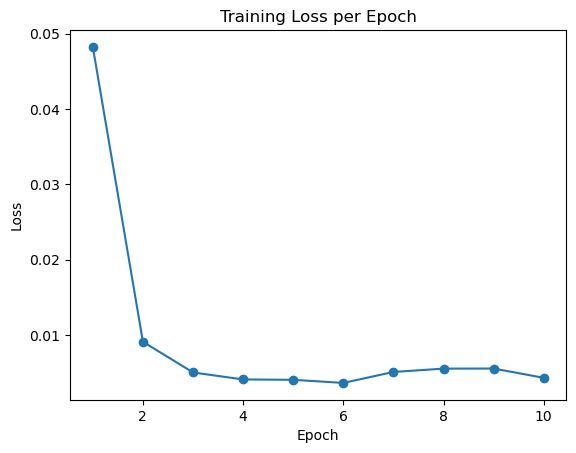

In [28]:
import torch.optim as optim
mlp_model = MLPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
loss_values = []

# Training loop
for epoch in range(10):
    for features, pos in mlp_dataloader:
        optimizer.zero_grad()
        predictions = mlp_model(features)
        loss = criterion(predictions, pos)
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Plot training loss for each epoch
plt.plot(range(1, 11), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()
# Save model
torch.save(mlp_model.state_dict(), "hw1_1.pth")

Test Part

In [29]:
import torch.nn.functional as F
import torch
import numpy as np
from homework1 import Hw1Env


def generate_test_data(N=5):
    """Mimics the main function but generates fewer samples for testing."""
    env = Hw1Env(render_mode="offscreen")
    positions = torch.zeros(N, 2, dtype=torch.float)
    actions = torch.zeros(N, dtype=torch.uint8)
    imgs = torch.zeros(N, 3, 128, 128, dtype=torch.uint8)

    for i in range(N):
        action_id = np.random.randint(4)  # Choose random action
        env.step(action_id)
        obj_pos, pixels = env.state()  # Get position and image

        positions[i] = torch.tensor(obj_pos)
        actions[i] = action_id
        imgs[i] = pixels
        env.reset()

    return actions, imgs, positions


# Generate small test dataset
test_actions, test_imgs, test_positions = generate_test_data(N=5)


# Load trained model
mlp_model = MLPModel()
mlp_model.load_state_dict(torch.load("mlp_model_better.pth"))
mlp_model.eval()

# Evaluate model
with torch.no_grad():
    print("\nEvaluation on Small Test Data:")
    print("=" * 50)

    for i in range(len(test_actions)):
        action_tensor = F.one_hot(test_actions[i].long(), num_classes=4).float()
        shape, size = extract_object_info(test_imgs[i])
        shape_tensor = torch.tensor([shape], dtype=torch.float32)
        size_tensor = torch.tensor([size], dtype=torch.float32)

        features = torch.cat([shape_tensor, size_tensor, action_tensor], dim=0).unsqueeze(0)

        # Predict position
        predicted_pos = mlp_model(features).squeeze(0)

        # Print results
        print(f"Sample {i+1}:")
        print(f"  Action Taken : {test_actions[i].item()}")
        print(f"  Shape: {'Cube' if shape == 0 else 'Sphere'}")
        print(f"  Size: {size:.2f}")
        print(f"  True Position: {test_positions[i].numpy()}")
        print(f"  Predicted Position: {predicted_pos.numpy()}")
        print("-" * 50)


Evaluation on Small Test Data:
Sample 1:
  Action Taken : 2
  Shape: Sphere
  Size: 0.05
  True Position: [0.6224543  0.23952371]
  Predicted Position: [0.57293016 0.3095674 ]
--------------------------------------------------
Sample 2:
  Action Taken : 3
  Shape: Sphere
  Size: 0.09
  True Position: [ 0.51616055 -0.3795341 ]
  Predicted Position: [ 0.57046264 -0.32571086]
--------------------------------------------------
Sample 3:
  Action Taken : 2
  Shape: Sphere
  Size: 0.05
  True Position: [0.60098237 0.24772997]
  Predicted Position: [0.57293016 0.3095674 ]
--------------------------------------------------
Sample 4:
  Action Taken : 0
  Shape: Sphere
  Size: 0.09
  True Position: [ 0.8254203 -0.0558697]
  Predicted Position: [0.9578144  0.03134092]
--------------------------------------------------
Sample 5:
  Action Taken : 3
  Shape: Sphere
  Size: 0.09
  True Position: [ 0.60765713 -0.24280918]
  Predicted Position: [ 0.57046264 -0.32571086]
-------------------------------

In [ ]:
def train():
    # Load dataset
    mlp_dataset = PositionDatasetMLP()
    mlp_dataloader = DataLoader(mlp_dataset, batch_size=32, shuffle=True)

    # Define model
    mlp_model = MLPModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
    loss_values = []

    # Training loop
    for epoch in range(10):
        for features, pos in mlp_dataloader:
            optimizer.zero_grad()
            predictions = mlp_model(features)
            loss = criterion(predictions, pos)
            loss.backward()
            optimizer.step()

        loss_values.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Plot training loss for each epoch
    plt.plot(range(1, 11), loss_values, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.show()

    # Save model
    torch.save(mlp_model.state_dict(), "hw1_1.pth")

In [ ]:
def test():
    test_actions, test_imgs, test_positions = generate_test_data(N=5)

    mlp_model = MLPModel()
    mlp_model.load_state_dict(torch.load("hw1_1.pth"))
    mlp_model.eval()
    # Evaluate model
    with torch.no_grad():
        print("\nEvaluation on Small Test Data:")
        print("=" * 50)

        for i in range(len(test_actions)):
            action_tensor = F.one_hot(test_actions[i].long(), num_classes=4).float()
            shape, size = extract_object_info(test_imgs[i])
            shape_tensor = torch.tensor([shape], dtype=torch.float32)
            size_tensor = torch.tensor([size], dtype=torch.float32)

            features = torch.cat([shape_tensor, size_tensor, action_tensor], dim=0).unsqueeze(0)

            # Predict position
            predicted_pos = mlp_model(features).squeeze(0)

            # Print results
            print(f"Sample {i+1}:")
            print(f"  Action Taken : {test_actions[i].item()}")
            print(f"  Shape: {'Cube' if shape == 0 else 'Sphere'}")
            print(f"  Size: {size:.2f}")
            print(f"  True Position: {test_positions[i].numpy()}")
            print(f"  Predicted Position: {predicted_pos.numpy()}")
            print("-" * 50)